# Global Spells data analysis

## Gathering data

All games from the period of time of the experiment were stored in game_all_global collection

In [1]:
import pymongo

client = pymongo.MongoClient()
db = client.pyke_2020
mongoTable = db["game_all_global"]

Static information

In [15]:
queue_types = {
    400:"Normal",
    420:"Ranked",
    430:"Normal",
    440:"Ranked",
    450:"Normal",
    700:"Clash",
    830:"Coop vs IA",
    840:"Coop vs IA",
    850:"Coop vs IA"
}

Some helper functions for banrates and pickrates data

In [2]:
def get_team_bans(game_data):
    team_bans = {100:[],200:[]}
    for t in game_data["teams"]:
        for b in t["bans"]:
            team_bans[t["teamId"]].append(b["championId"])
    return team_bans

def get_team_picks(game_data):
    team_picks = {100:[],200:[]}
    for p in game_data["participants"]:
        team_picks[p["teamId"]].append(p["championId"])
    return team_picks

def get_team_result(game_data):
    for t in game_data["teams"]:
        if "win" in t:
            if t["win"] == "Win":
                winning_team = t["teamId"]
                losing_team = 100 if winning_team == 200 else 200
            else:
                losing_team = t["teamId"]
                winning_team = 100 if losing_team == 200 else 200
            return winning_team, losing_team

In [3]:
picks = []
bans = []
for g in mongoTable.find({},{"participants":1, "gameId":1, "queueId":1, "teams":1, "gameCreation":1}):
    # Considering only ranked data
    if len(g["participants"]) < 10 or not g["queueId"] in [420,440]:
        continue
    team_bans = get_team_bans(g)
    team_picks = get_team_picks(g)
    winning_team, losing_team = get_team_result(g)


    for b in team_bans[winning_team] + team_bans[losing_team]:
        bans.append({
            "gameId": g["gameId"],
            "timestamp": g["gameCreation"],
            "queuId": g["queueId"],
            "championId": b
        })

    for p in team_picks[winning_team]:
        picks.append({
            "gameId": g["gameId"],
            "timestamp": g["gameCreation"],
            "queuId": g["queueId"],
            "championId": p,
            "win": True
        })

    for p in team_picks[losing_team]:
        picks.append({
            "gameId": g["gameId"],
            "timestamp": g["gameCreation"],
            "queuId": g["queueId"],
            "championId": p,
            "win": False
        })

Putting everything into DataFrames

In [4]:
import pandas as pd
df_bans = pd.DataFrame(bans)
df_picks = pd.DataFrame(picks)

Helper function for global spell detection

In [6]:
def get_team_damages(g):
    t_dam = {100:0,200:0}
    for p in g["participants"]:
        t_dam[p["teamId"]] += p["stats"]["totalDamageDealt"]
    return t_dam

def get_team_kills(g):
    t_kills = {100:0,200:0}
    for p in g["participants"]:
        t_kills[p["teamId"]] += p["stats"]["kills"]
    return t_kills

def get_team_cs(g):
    t_cs = {100:0,200:0}
    for p in g["participants"]:
        t_cs[p["teamId"]] += p["stats"]["totalMinionsKilled"]
    return t_cs

Finding games with some heuristics

In [ ]:
for g in mongoTable.find({},{"participants":1, "gameId":1, "gameDuration":1}):
    teams_damages = get_team_damages(g)
    teams_cs = get_team_cs(g)
    for p in g["participants"]:
        other_team = 100 if p["teamId"] == 200 else 100
        # At least 80% damages dealt
        if p["stats"]["totalDamageDealt"] > teams_damages[p["teamId"]] * 0.8:
            print(g["gameId"])
        # At least 80%  CS and at least 20 CS
        if p["stats"]["totalMinionsKilled"] > teams_cs[p["teamId"]] * 0.8 and p["stats"]["totalMinionsKilled"] > 20:
            print(g["gameId"])
        # More than 40 kills
        if p["stats"]["kills"] > 40:
            print(g["gameId"])

These heuristics are error prone and all games are manually reviewed. Additionally, all the matchlists of the accounts convinced with bug abuse are reviewed to check if they played since June 2020, and to find other games that haven't been catched by the heuristics.

The list of gameId with confirmed bug abuse, as well as the list of accounts having played since June 2020, are stored in additional flies, but won't be disclosed due to privacy reasons.

In [7]:
import json

with open("../confirmed_bug_abuse.json","r") as f:
    games_confirmed = json.load(f)
with open("../accounts_banned.json","r") as f:
    accounts_banned = json.load(f)

Getting all confirmed games data in memory

In [8]:
games = []
for g in mongoTable.find({"gameId":{"$in":games_confirmed}},{"participants":1, "gameId":1, "queueId":1, "gameCreation":1, "participantIdentities":1}):
    games.append(g)

Extracting data from matches, with some cases manually handled with complex_cases_handled and very_complex_cases_handled variables

In [44]:
players_abusing = []
players_with = []
for g in games:
    n_champions = 0
    champion_list = [p["championId"] for p in g["participants"]]
    champion_by_pId = {p["participantId"]:p["championId"] for p in g["participants"]}
    win_by_pId = {p["participantId"]:p["stats"]["win"] for p in g["participants"]}
    if 78 in champion_list:
        n_champions += 1
    if 141 in champion_list:
        n_champions += 1
    if 420 in champion_list:
        n_champions += 1
    
    # If there is more than one suspected champion, check the manually handle cases
    if n_champions > 1:
        if g["gameId"] in complex_cases_handled:
            abuser_pId, abuser_team = complex_cases_handled[g["gameId"]]
            
        elif g["gameId"] in very_complex_cases_handled:
            abuser_pIds, abuser_team = very_complex_cases_handled[g["gameId"]]
            player_with_pId = [p["participantId"] for p in g["participants"] if not p["participantId"] in abuser_pIds and p["teamId"] == abuser_team]
            for p in g["participantIdentities"]:
                if p["participantId"] in abuser_pIds:
                    players_abusing.append({
                        "gameId":g["gameId"],
                        "timestamp":g["gameCreation"],
                        "accountId":p["player"]["matchHistoryUri"].split("/")[5],
                        "queueId":g["queueId"],
                        "queueType":queue_types[g["queueId"]],
                        "championId":champion_by_pId[p["participantId"]],
                        "win":win_by_pId[p["participantId"]]
                    })
                elif p["participantId"] in player_with_pId:
                    players_with.append({
                        "gameId":g["gameId"],
                        "timestamp":g["gameCreation"],
                        "accountId":p["player"]["matchHistoryUri"].split("/")[5],
                        "queueId":g["queueId"],
                        "queueType":queue_types[g["queueId"]],
                        "championId":champion_by_pId[p["participantId"]],
                        "win":win_by_pId[p["participantId"]]
                    })
            
            
            continue
        else:
            damages = sorted([p["stats"]["totalDamageDealt"] for p in g["participants"]], reverse=True)
            if (damages[0] / 5) > damages[1]:
                #print(damages[0] / 5, damages[1], g["gameId"])
                abuser_pId, abuser_team, abuser_cId = \
                    [(p["participantId"],p["teamId"], p["championId"]) for p in g["participants"] if p["stats"]["totalDamageDealt"] == damages[0]][0]
                if not abuser_cId in [78,141,420]:
                    print("complex case", g["gameId"])
                    continue
            else:
                print("complex case", g["gameId"])
                continue
            
        
    else:
        abuser_pId, abuser_team = [(p["participantId"],p["teamId"]) for p in g["participants"] if  p["championId"] in [78,141,420]][0]
    
    player_with_pId = [p["participantId"] for p in g["participants"] if not p["participantId"] == abuser_pId and p["teamId"] == abuser_team]

    for p in g["participantIdentities"]:
        if p["participantId"] == abuser_pId:
            players_abusing.append({
                "gameId":g["gameId"],
                "timestamp":g["gameCreation"],
                "accountId":p["player"]["matchHistoryUri"].split("/")[5],
                "queueId":g["queueId"],
                "queueType":queue_types[g["queueId"]],
                "championId":champion_by_pId[p["participantId"]],
                "win":win_by_pId[p["participantId"]]
            })
        elif p["participantId"] in player_with_pId:
            players_with.append({
                "gameId":g["gameId"],
                "timestamp":g["gameCreation"],
                "accountId":p["player"]["matchHistoryUri"].split("/")[5],
                "queueId":g["queueId"],
                "queueType":queue_types[g["queueId"]],
                "championId":champion_by_pId[p["participantId"]],
                "win":win_by_pId[p["participantId"]]
            })
df_players_abusing = pd.DataFrame(players_abusing)
df_players_with = pd.DataFrame(players_with)

In [45]:
df_players_abusing["queueType"] = pd.Categorical(df_players_abusing['queueType'], ["Coop vs IA","Normal","Ranked","Clash"])

## Analyzing data

### Games distribution

Finding the number of games per type of games

In [24]:
df_players_abusing.drop_duplicates("gameId").sort_values("queueType")["queueType"].value_counts()

Ranked        541
Normal         64
Coop vs IA      6
Clash           3
Name: queueType, dtype: int64

Plotting it into a pie chart

[]

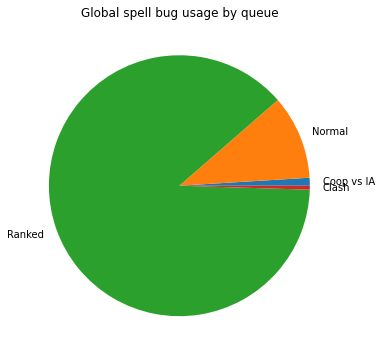

In [26]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(facecolor="w")

df_players_abusing.drop_duplicates("gameId").sort_values("queueType")["queueType"].value_counts().sort_index().plot.pie(ax=ax, figsize=(6,6))
ax.set_title('Global spell bug usage by queue')
ax.set_ylabel("")
ax.set_xlabel("")
plt.plot()

### Champions used

Number of games per champions

In [28]:
df_players_abusing["championId"].value_counts()

78     558
141     37
420     22
Name: championId, dtype: int64

78 is for Poppy, 141 for Kayn and 420 for Illaoi (http://ddragon.leagueoflegends.com/cdn/11.6.1/data/en_US/champion.json)

[]

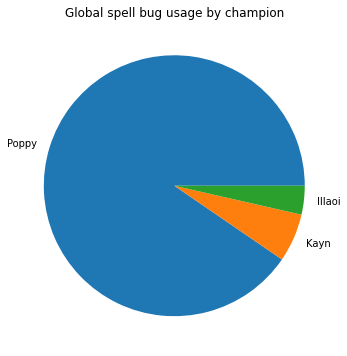

In [27]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(facecolor="w")

df_players_abusing["championId"].value_counts().sort_index().plot.pie(ax=ax, figsize=(6,6), labels=["Poppy","Kayn","Illaoi"])
ax.set_title('Global spell bug usage by champion')
ax.set_ylabel("")
ax.set_xlabel("")
plt.plot()

### Games per player

Here we will measure another metric, which is the number of games with the Viego bug, that each player played in

In [29]:
df_games_per_player = pd.DataFrame(
    [
        df_players_abusing.groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index(), 
        df_players_abusing[df_players_abusing["queueType"] == "Ranked"].groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index()
    ], 
    index=["All", "Ranked"]
) \
.fillna(0) \
.astype(int).T

df_games_per_player

,All,Ranked
1,62,52
2,43,36
3,29,22
4,22,20
5,9,9
6,9,8
7,8,6
8,5,5
9,1,1
11,1,1


The index represents the number of games, and the value in the table, the number of games. For instance, 223 players used the bug only once in Ranked, and 3 players used it 10 times regardless of the queue.

We can do the same operation for the allied players

In [30]:
df_games_per_player_with = pd.DataFrame(
    [
        df_players_with.groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index(), 
        df_players_with[df_players_with["queueType"] == "Ranked"].groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index()
    ], 
    index=["All", "Ranked"]
) \
.fillna(0) \
.astype(int).T

df_games_per_player_with

,All,Ranked
1,1890,1638
2,56,45
3,18,14
4,11,10
5,5,5
6,6,6
7,4,5
8,2,2
9,3,2
10,6,6


Of course, the number for playing once with an abuser is very high, but with high chance to be coincidence. With 2 or 3 games and more with an abuser, chances are very low that these players didn't intentionally queue up with an abuser.

Getting the table into markdown format with tabulate

In [31]:
from tabulate import tabulate
print(tabulate(df_games_per_player, tablefmt="pipe", headers="keys"))

|    |   All |   Ranked |
|---:|------:|---------:|
|  1 |    62 |       52 |
|  2 |    43 |       36 |
|  3 |    29 |       22 |
|  4 |    22 |       20 |
|  5 |     9 |        9 |
|  6 |     9 |        8 |
|  7 |     8 |        6 |
|  8 |     5 |        5 |
|  9 |     1 |        1 |
| 11 |     1 |        1 |
| 13 |     1 |        1 |
| 15 |     2 |        2 |
| 16 |     1 |        1 |
| 20 |     1 |        1 |


In [32]:
print(tabulate(df_games_per_player_with, tablefmt="pipe", headers="keys"))

|    |   All |   Ranked |
|---:|------:|---------:|
|  1 |  1890 |     1638 |
|  2 |    56 |       45 |
|  3 |    18 |       14 |
|  4 |    11 |       10 |
|  5 |     5 |        5 |
|  6 |     6 |        6 |
|  7 |     4 |        5 |
|  8 |     2 |        2 |
|  9 |     3 |        2 |
| 10 |     6 |        6 |
| 12 |     1 |        1 |
| 14 |     4 |        4 |
| 16 |     1 |        1 |
| 18 |     1 |        1 |
| 22 |     1 |        1 |
| 37 |     1 |        1 |


### Pickrate and banrate

Getting the pickrate and banrate of Poppy, as being the most used champion for the bug, and the one presented in the Reddit thread

In [33]:
# Filtering timestamps to ensure it's in the right period of time
df_picks = df_picks[df_picks["timestamp"] >= 1592352000000]

# Transforming into date format
df_picks['date'] = pd.to_datetime(df_picks['timestamp'], unit='ms')
df_picks['date'] = df_picks['date'].dt.date

# Getting just the number of games
df_games_picks = df_picks[["date","gameId"]]
df_games_picks.drop_duplicates(inplace=True)
df_games_picks.groupby("date").count()["gameId"]

<ipython-input-33-b783b2ae09e6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_picks.drop_duplicates(inplace=True)


date
2020-06-17    257506
2020-06-18    271775
2020-06-19    255328
2020-06-20    245866
2020-06-21    267905
2020-06-22    272636
2020-06-23    264427
Name: gameId, dtype: int64

Getting the games where Poppy is picked

In [34]:
df_poppy_picks = df_picks[df_picks["championId"] == 78]

Computing the pickrate per day

In [35]:
df_pickrate = pd.DataFrame([df_games_picks.groupby("date").count()["gameId"], df_poppy_picks.groupby("date").count()["gameId"]], index=["games","picks"]).T.sort_index()
df_pickrate["pickrate"] = df_pickrate["picks"] / df_pickrate["games"] *100
df_pickrate

,games,picks,pickrate
date,,,
2020-06-17,257506,7514,2.917990
2020-06-18,271775,7778,2.861926
2020-06-19,255328,8029,3.144583
2020-06-20,245866,7155,2.910122
2020-06-21,267905,7787,2.906627
2020-06-22,272636,7641,2.802638
2020-06-23,264427,7330,2.772032


Same operations with bans

In [36]:
# Filtering timestamps to ensure it's in the right period of time
df_bans = df_bans[df_bans["timestamp"] >= 1592352000000]

# Transforming into date format
df_bans['date'] = pd.to_datetime(df_bans['timestamp'], unit='ms')
df_bans['date'] = df_bans['date'].dt.date

# Getting just the number of games
df_games_bans = df_bans[["date","gameId"]]
df_games_bans.drop_duplicates(inplace=True)
df_games_bans.groupby("date").count()["gameId"]

<ipython-input-36-240c2111e52b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_bans.drop_duplicates(inplace=True)


date
2020-06-17    257506
2020-06-18    271775
2020-06-19    255328
2020-06-20    245866
2020-06-21    267905
2020-06-22    272636
2020-06-23    264427
Name: gameId, dtype: int64

In [37]:
df_poppy_bans = df_bans[df_bans["championId"] == 78]

Finding Poppy banrate rank before and after the Reddit thread

In [52]:
# The iloc is used to find the champion at which rank
df_bans[df_bans["date"] == pd.to_datetime("2020-06-17")].groupby("championId").count().sort_values("gameId", ascending=False).iloc[126].name

78

In [53]:
df_bans[df_bans["date"] == pd.to_datetime("2020-06-19")].groupby("championId").count().sort_values("gameId", ascending=False).iloc[72].name

78

### Number of games with abuse

Getting the number of games with abuse per day to match the pickrate and banrate data

In [39]:
df_banrate = pd.DataFrame([df_games_bans.groupby("date").count()["gameId"], df_poppy_bans.groupby("date").count()["gameId"]], index=["games","bans"]).T.sort_index()
df_banrate["banrate"] = df_banrate["bans"] / df_banrate["games"] *100
df_banrate

,games,bans,banrate
date,,,
2020-06-17,257506,967,0.375525
2020-06-18,271775,1051,0.386717
2020-06-19,255328,6173,2.417675
2020-06-20,245866,3238,1.316978
2020-06-21,267905,2404,0.897333
2020-06-22,272636,1999,0.733212
2020-06-23,264427,1763,0.666725


In [47]:
df_players_abusing['date'] = pd.to_datetime(df_players_abusing['timestamp'], unit='ms')
df_players_abusing['date'] = df_players_abusing['date'].dt.date

df_games_abused = df_players_abusing[["date","gameId"]]
df_games_abused.drop_duplicates(inplace=True)
df_games_abused.groupby("date").count()["gameId"]

<ipython-input-47-036b8cf26685>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_abused.drop_duplicates(inplace=True)


date
2020-06-18     75
2020-06-19    392
2020-06-20     35
2020-06-21     58
2020-06-22     32
2020-06-23     22
Name: gameId, dtype: int64

[]

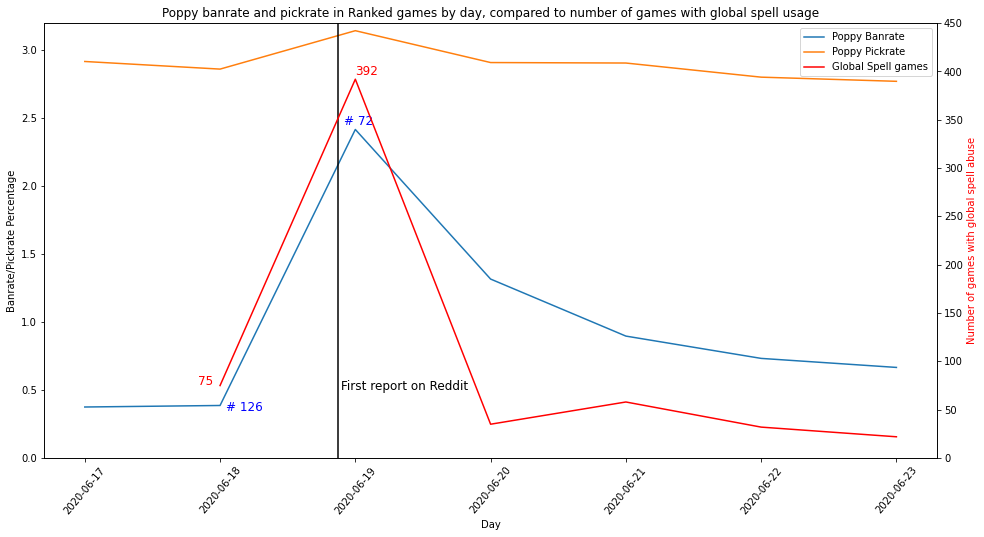

In [54]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

# Adding pickrate and banrate
df_banrate["banrate"].plot(ax=ax, figsize=(16,8), label="Poppy Banrate")
df_pickrate["pickrate"].plot(ax=ax, label="Poppy Pickrate")

plt.xticks(rotation=50)

# Line for Reddit thread
ax.axvline(x="2020-06-18 21:00:00", color="black")
ax.text("2020-06-18 21:30:00", 0.5, "First report on Reddit", fontsize=12)

# Poppy banrate rank
ax.text("2020-06-18 01:00:00", 0.35, "# 126", fontsize=12, color="blue")
ax.text("2020-06-18 22:00:00", 2.45, "# 72", fontsize=12, color="blue")

ax.set_ylim((0,3.2))

# Plotting the number of game abused per day
ax2 = ax.twinx()

color="red"
df_games_abused.groupby("date").count().plot(ax=ax2, color=color, label="Global Spell games")
ax2.set_ylabel('Number of games with global spell abuse', color=color)
ax2.set_ylim((0,450))

# Adding the number of games
ax2.text("2020-06-17 20:00:00", 76, "75", fontsize=12, color=color)
ax2.text("2020-06-19 00:00:00", 396, "392", fontsize=12, color=color)

# Updating legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+["Global Spell games"])
ax2.get_legend().remove()

ax.set_ylabel("Banrate/Pickrate Percentage")
ax.set_xlabel("Day")
ax.set_title("Poppy banrate and pickrate in Ranked games by day, compared to number of games with global spell usage")
plt.plot()